# Initialization

## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
    
import torchvision.transforms.functional as tF

from utils.save_load_utils import save_model, load_model
from utils.visualization_utils import save_pred_masks, visualize_segmentation, plot_segmentation
                                                                     
import albumentations as A

%matplotlib inline
import os
import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False

%load_ext autoreload
%autoreload 2


USING DEVICE: cuda


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

## Hyperparameters

In [2]:
hyperparameters = {
    'test_dir' : './images/test',
    'train_dir' : './images/train',
    'seed' : 9999,
    'dataloader' :{
        'batch_size' : 8,
        'num_workers' : 4,
        'pin_memory' : False, 
    },
    'optimizer' :{
        'lr' : 1e-4,
        'betas' : (0.9, 0.999),
        'weight_decay' : 1e-4,
    },
    'epochs' : 150,
    'training_size' : 0,
    'test_size': 0,
    'gradient_clipping' : 1.0,
    'vgg19': {
        'in_channels': 3,
        'out_channels': 1,
        'features': 64,
    }, 
    'pre_trained_path': 'checkpoints/pretrained/pretrained_best.pth.tar',
    'checkpoints_dir': './checkpoints/daft',
    'output_dir':{
        'results':'../generated_examples/',
        'model':'../generated_examples/daft/',
    },
}

## Seed Everything

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(hyperparameters['seed'])

# Data Preprocessing

## Data Augmentation

In [ ]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

## Dataset

In [5]:
from dataset.dataset import seg_datasets

train_dataset = seg_datasets(hyperparameters['train_dir'], train_transforms)
test_dataset = seg_datasets(hyperparameters['test_dir'], test_transforms)

len(train_dataset), len(test_dataset)

(104, 27)

In [7]:
hyperparameters['training_size'] = len(train_dataset)
hyperparameters['test_size'] = len(test_dataset)

In [8]:
sample = train_dataset[30]
torch.unique(sample[1])

tensor([0., 1., 2., 3.])

In [9]:
img, mask = train_dataset[20]
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


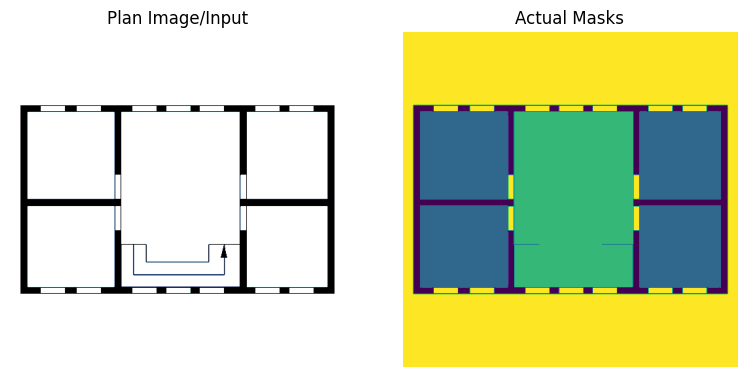

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout()
ax1.axis('off')
ax1.set_title('Plan Image/Input')
ax1.imshow(img.permute(1, 2, 0).numpy())
    
ax2.axis('off')
ax2.set_title('Actual Masks')
ax2.imshow(mask.numpy().transpose(1,2,0))

## Color Mapping

In [11]:
color_mapping = {
    0: (0, 0, 0),         # Walls
    1: (255, 80, 80),     # Iwan
    2: (80, 80, 255),     # Room
    3: (255, 255, 255),   # Background
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

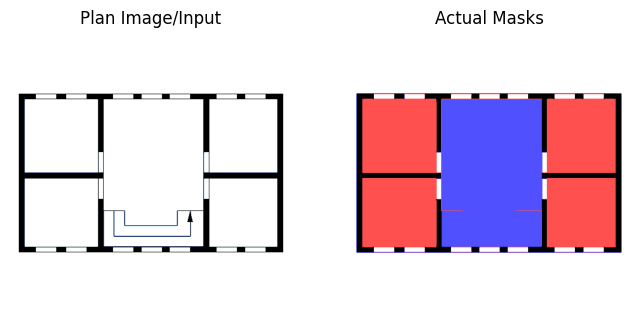

In [12]:
visualization = visualize_segmentation(mask, color_mapping, from_tensor=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(img.permute(1, 2, 0).numpy())
ax1.set_title('Plan Image/Input')
ax1.axis('off')

ax2.imshow(visualization)
ax2.set_title('Actual Masks')
ax2.axis('off')

## Dataloader

In [13]:
from utils.dataloader_utils import get_loader

train_dataloader, test_dataloader = get_loader(
    train_dir = hyperparameters['train_dir'],
    test_dir = hyperparameters['test_dir'],
    batch_size = hyperparameters['dataloader']['batch_size'],
    train_transform = train_transforms,
    test_transform = test_transforms,
    num_workers = hyperparameters['dataloader']['num_workers'],
    pin_memory = hyperparameters['dataloader']['pin_memory']
)

len(train_dataloader), len(test_dataloader)

(13, 4)

In [14]:
img_a_batch, img_b_batch = next(iter(train_dataloader))
print(img_a_batch.shape, img_b_batch.shape)
print(img_a_batch.size(0))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])
8


# Model

## Model Loading

In [15]:
from models.vgg19 import VGGUNET19

model = VGGUNET19(
    features = hyperparameters['vggunet']['features'], 
    in_channels=hyperparameters['vggunet']['in_channels'], 
    out_channels=hyperparameters['vggunet']['out_channels']
)

In [ ]:
checkpoint = torch.load(hyperparameters['pre_trained_path'])
model.load_state_dict(checkpoint['model_state_dict'], strict=True)

model.to(device)

In [ ]:
# Tüm katmanları serbest bırakmak yerine yalnızca son birkaç katmanı güncellemek için "requires_grad" ayarı yapılır.
for param in model.parameters():
    param.requires_grad = False

# Yeni veri bölgesine uyum sağlamak için encoder'ın en üst katmanları ve decoder katmanları açılır
for layer in [model.inc, model.down1, model.down2, model.up3, model.up4, model.out]:
    for param in layer.parameters():
        param.requires_grad = True

## Number of Parameters

In [19]:
### Dummy Data
__batch_size = 1
__in_channels = hyperparameters['vggunet']['in_channels']
__width = 512
__height = 512

dummy_input = torch.randn((__batch_size, __in_channels, __height, __width))
dummy_out = model(dummy_input)

print(f'Model input size: {dummy_input.shape}')
print(f'Model output size: {dummy_out.shape}')

Model input size: torch.Size([1, 3, 320, 320])
Model output size: torch.Size([1, 1, 320, 320])


In [20]:
print(f'Number of Parameters: {sum(dummy_out.numel() for p in model.parameters()):,}')

Number of Parameters: 9,932,800


# Loss & Optimizer

## Loss Function

In [22]:
criterion = nn.MSELoss(reduction='none')

def loss_fn(pred, mask, alpha=0.01):
    
    loss_by_pixel = criterion(pred, mask)
    loss = loss_by_pixel.mean()
    
    return loss

## Optimizer & Scheduler

In [25]:
learning_rate = hyperparameters['optimizer']['lr']
betas = hyperparameters['optimizer']['betas']

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    betas = betas, 
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', patience=40, factor=0.1)

# Training

## Train Function

In [26]:
def train_fn(
    epoch,
    model,
    dataloader, 
    optimizer, 
    criterion, 
    device,
    gradient_clipping,
):
    
    model.train()
    
    compute_avg = lambda x: sum(x) / len(x)
    avg_loss = []
    
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['training_size'], desc=f'Train/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()

            pred_mask = model(img)

            loss = criterion(pred=pred_mask,mask=mask)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            optimizer.step()

            # Record Results
            avg_loss.append(loss.item())
            
            pbar.update(img.shape[0])
        
    return compute_avg(avg_loss) 

## Evaluation Function

In [27]:
from utils.evaluation_utils import calculate_miou, check_acc

@torch.no_grad()
def eval_fn(
    epoch,
    model, 
    dataloader, 
    criterion, 
    device,
    color_mapping,
):
    model.eval()
    
    # Average Loss and mIoU
    avg_loss = []
    avg_mIoU = []
    
    #Accuracy
    total_correct = 0
    total_pixel = 0

    compute_avg = lambda x: sum(x) / len(x)
    
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['test_size'], desc=f'Eval/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            #Accuracy
            num_correct, num_pixel = check_acc(img, mask, model, device)
            total_correct += num_correct
            total_pixel += num_pixel

            pred_mask = model(img)
            loss = criterion(pred=pred_mask,mask=mask)

            # mIoU
            miou = calculate_miou(pred_mask, mask, color_mapping)

            avg_loss.append(loss.item())
            avg_mIoU.append(miou.item())
            
            pbar.update(img.shape[0])

    acc = 100*(num_correct/num_pixel)
    return compute_avg(avg_loss), compute_avg(avg_mIoU), acc

## Start Training

In [28]:
best_model = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

history = {
    'train_loss': [],
    'eval_loss' : [],
    'eval_miou' : [],
    'eval_acc' : [],
}

In [29]:
def train_start():
    model.to(device)
    writer = SummaryWriter('runs/vggunet19_model1')
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            model = model,
            dataloader = train_dataloader, 
            optimizer = optimizer, 
            criterion = loss_fn, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            model = model, 
            dataloader = test_dataloader, 
            criterion = loss_fn, 
            device = device,
            color_mapping = color_mapping,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} |
        Average Test Loss: {eval_loss:.4f} |
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc}""")
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)
        history['eval_miou'].append(eval_miou)
        history['eval_acc'].append(eval_acc)
        
        save_model(
            model=model, 
            optimizer=optimizer, 
            root_folder=hyperparameters['checkpoints_dir'], 
            file_name='Daft_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model['best_eval_miou']:
            best_model['best_state_dict'] = model1.state_dict().copy()
            best_model['best_epoch'] = epoch
            best_model['best_eval_loss'] = eval_loss
            best_model['best_eval_miou'] = eval_miou
            best_model['best_eval_acc'] = eval_acc
            
            save_model(
                model=model, 
                optimizer=optimizer, 
                root_folder=hyperparameters['checkpoints_dir']['model1'], 
                file_name='Daft_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model1, 
                last_epoch=epoch, 
                verbose=True)
            
        scheduler.step(eval_loss)
        
    writer.close()

## Model Training

In [ ]:
train_start()

# Result

## Print Result Comparison

In [ ]:
print(
    f"""
    Best of Model:
        - Epoch Number: {best_model['best_epoch']}
        - Evaluation Loss: {best_model['best_eval_loss']}
        - Evaluation mIoU: {best_model['best_eval_miou']}
        - Evaluation Accuracy: {best_model['best_eval_acc']}

    """
)

## Plot Comparisons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


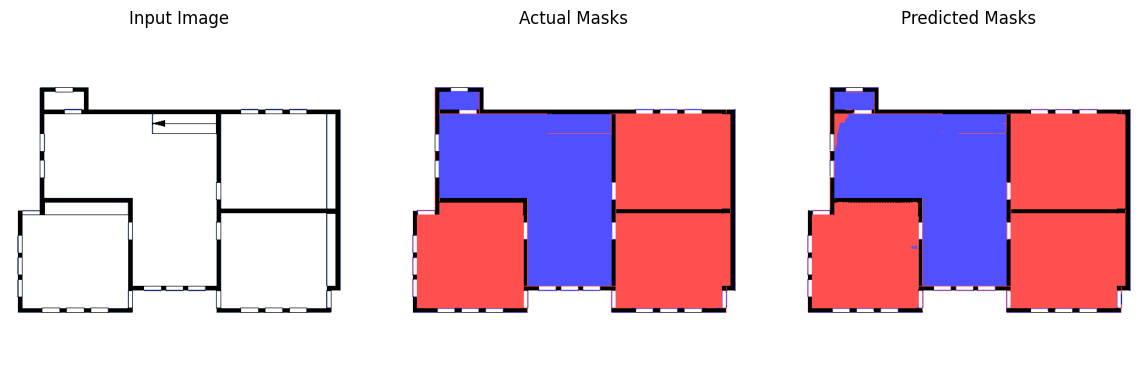

In [34]:
plot_segmentation(
    model=model, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='daft_seg_fig', 
    save_format='png', 
    close_img=False
)

## Save Predictions

In [36]:
# Model1 Saving
save_pred_masks(
    model=model,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

## History Graphs

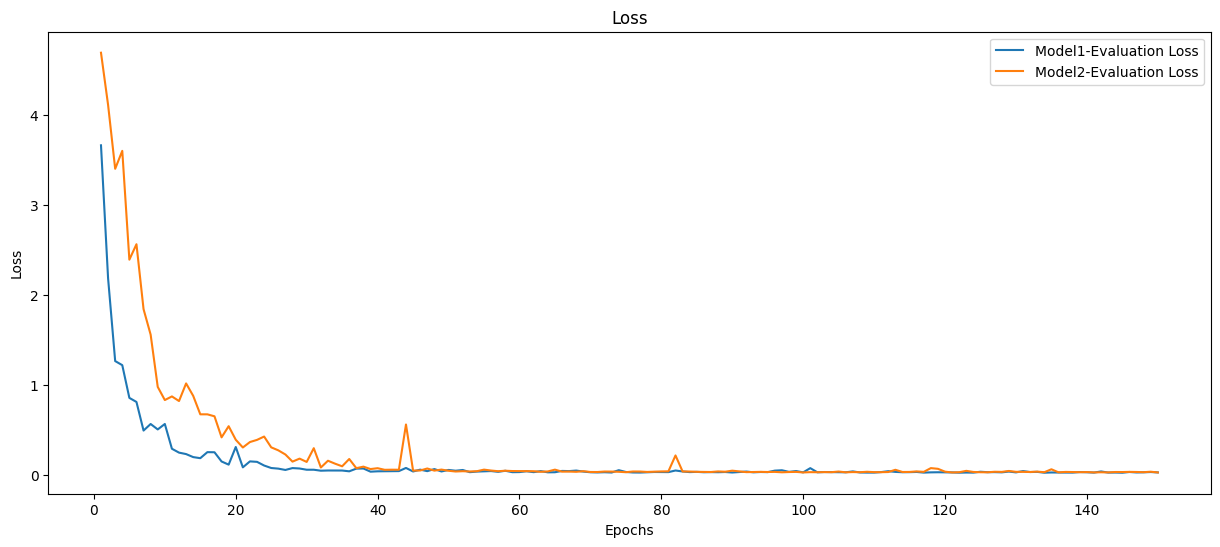

In [38]:
epoch_range = np.arange(1, hyperparameters['epochs']+1, 1, dtype=int)

plt.figure(figsize = (15,6))
plt.title(f"Loss")
plt.plot(epoch_range, history['model']['eval_loss'], label="Model-Evaluation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
loss_dir = os.path.join(hyperparameters['output_dir']['results'], 'loss_graph.png')
plt.savefig(loss_dir, format='png', bbox_inches='tight')

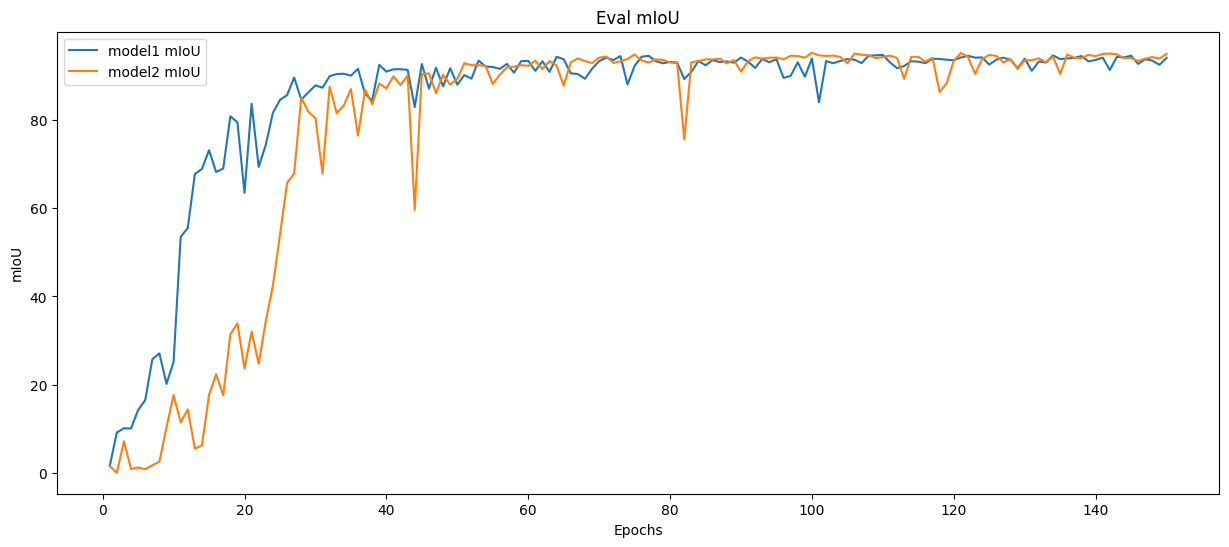

In [39]:
plt.figure(figsize = (15,6))
plt.title(f"Eval mIoU")
plt.plot(epoch_range, history['eval_miou'], label="Model mIoU")
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.legend();
miou_dir = os.path.join(hyperparameters['output_dir']['results'], 'miou_graph.png')
plt.savefig(miou_dir, format='png', bbox_inches='tight')

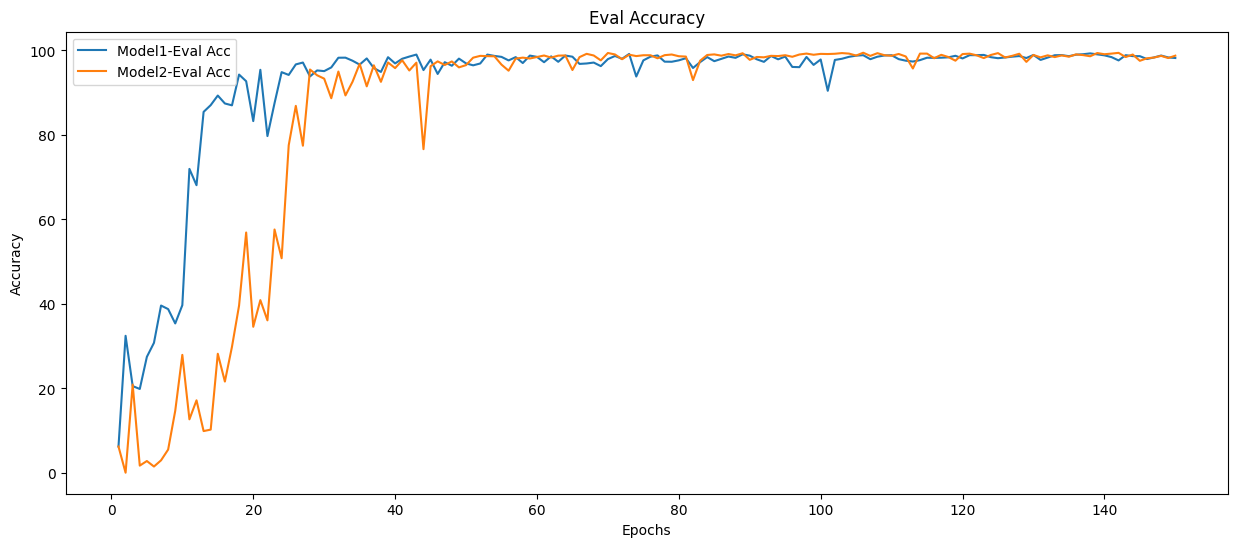

In [40]:
acc_tensor = torch.tensor(history['eval_acc'])
acc_tensor = acc_tensor.to('cpu')
acc_list = acc_tensor.tolist()

plt.figure(figsize = (15,6))
plt.title(f"Eval Accuracy")
plt.plot(epoch_range, acc_list, label="Model-Eval Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
acc_dir = os.path.join(hyperparameters['output_dir']['results'], 'accuracy_graph.png')
plt.savefig(acc_dir, format='png', bbox_inches='tight')